<a href="https://colab.research.google.com/github/MemoryLeeks13/LSTM_Text_Generation/blob/main/Assignment4_Piccione_John.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this assignment, I chose Shakespeare and song lyrics as my datasets. Two very different domains. I got both of these datasets from Kaggle.

Shakespeare: https://www.kaggle.com/datasets/kingburrito666/shakespeare-plays

Song lyrics: https://www.kaggle.com/datasets/deepshah16/song-lyrics-dataset

In [ ]:
# Load the lyrics dataset and get some useful information about it
import os
import pandas as pd
import re
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

EPOCHS = 20
BATCH_SIZE = 128
WINDOW_LENGTH = 40
WINDOW_STEP = 3

lyrics_dir = '/content/drive/MyDrive/song_lyrics'
all_lyrics = []

files = [f for f in os.listdir(lyrics_dir) if f.endswith('.csv')]
print(f"Found {len(files)} CSV files.")

sample_file = os.path.join(lyrics_dir, files[0])
df = pd.read_csv(sample_file)
print(df.columns)

for filename in os.listdir(lyrics_dir):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(lyrics_dir, filename))
        if 'Lyric' in df.columns:
            for lyric in df['Lyric'].dropna():
                all_lyrics.append(lyric)

Found 21 CSV files.
Index(['Unnamed: 0', 'Artist', 'Title', 'Album', 'Year', 'Date', 'Lyric'], dtype='object')


In [ ]:
# Preprocess the lyrics dataset
def clean_lyric(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

lyrics_clean = ["[LYR] " + clean_lyric(lyric) for lyric in all_lyrics]

Now let's load and preprocess the Shakespeare dataset

In [ ]:
shakespeare_df = pd.read_csv("/content/drive/MyDrive/Shakespeare_data.csv")

print(shakespeare_df.columns)

lines = shakespeare_df['PlayerLine'].dropna().tolist()

def clean_shakespeare_line(line):
    line = line.lower()
    line = re.sub(r'\[.*?\]', '', line)
    line = re.sub(r'[^a-z\s]', '', line)
    line = re.sub(r'\s+', ' ', line)
    return line.strip()


shakespeare_clean = ["[SHK] " + clean_shakespeare_line(line) for line in lines]

Index(['Dataline', 'Play', 'PlayerLinenumber', 'ActSceneLine', 'Player',
       'PlayerLine'],
      dtype='object')


Now lets merge the two datasets

In [ ]:
combined_text = " ".join(shakespeare_clean + lyrics_clean)
print(f"Total characters: {len(combined_text):,}")


# Save to Drive
drive_path = "/content/drive/MyDrive/combined_text_dataset.txt"
with open(drive_path, "w", encoding="utf-8") as f:
    f.write(combined_text)

print(f"Saved to Google Drive: {drive_path}")


Total characters: 15,509,153
Saved to Google Drive: /content/drive/MyDrive/combined_text_dataset.txt


We have over 15.5 million total characters, let's see how each dataset is represented.

In [ ]:
shakespeare_chars = sum(len(line) for line in shakespeare_clean)
lyrics_chars = sum(len(line) for line in lyrics_clean)

print(f"Shakespeare total characters: {shakespeare_chars:,}")
print(f"Lyrics total characters:      {lyrics_chars:,}")

Shakespeare total characters: 4,715,383
Lyrics total characters:      10,676,394


In [ ]:
import random

print("Shakespeare Samples:\n")
for _ in range(5):
    print(random.choice(shakespeare_clean))

print("\nLyrics Samples:\n")
for _ in range(5):
    print(random.choice(lyrics_clean))

Shakespeare Samples:

[SHK] lovers to bed tis almost fairy time
[SHK] afraid he would prove the better counterfeit
[SHK] ay by my troth the case may be amended
[SHK] to lingering sufferance answer me tomorrow
[SHK] majesty and your greatuncle edward the plack

Lyrics Samples:

[LYR] i i cant lie im scared to open my eyes cause what if i find nothing at all nothing at all what is the point of my lips if they dont make noise oh what is the point of doing nothing at all watching it fall pre the flicker burning you know the time is running running out only i see oh the diamonds diamonds breaking down i wont stay quiet i wont stay quiet cause staying silents the same as dying i wont stay quiet the flickers burning now this is not a this is not a swan swan song this is not a this is not a swan swan song we just gotta we just gotta hold on tonight this is not a this is not a swan song swan song swan dive yeah its a new life real fantasy wishing it was makebelieve oh what is the reason of doin

In [ ]:
# Encode characters as indices.
unique_chars = list(set(combined_text))
char_to_indx = dict((ch, index) for index,
                     ch in enumerate(unique_chars))
indx_to_char = dict((index, ch) for index,
                     ch in enumerate(unique_chars))

print(char_to_indx)
print(indx_to_char)

{'e': 0, 'c': 1, 'v': 2, 'j': 3, 'a': 4, 'n': 5, 'Y': 6, 'y': 7, 'w': 8, 's': 9, 'f': 10, 'g': 11, 't': 12, 'r': 13, 'i': 14, 'x': 15, 'H': 16, 'u': 17, 'b': 18, 'k': 19, '[': 20, 'L': 21, ' ': 22, 'q': 23, 'd': 24, 'm': 25, 'z': 26, 'h': 27, 'S': 28, 'p': 29, 'l': 30, 'o': 31, 'K': 32, 'R': 33, ']': 34}
{0: 'e', 1: 'c', 2: 'v', 3: 'j', 4: 'a', 5: 'n', 6: 'Y', 7: 'y', 8: 'w', 9: 's', 10: 'f', 11: 'g', 12: 't', 13: 'r', 14: 'i', 15: 'x', 16: 'H', 17: 'u', 18: 'b', 19: 'k', 20: '[', 21: 'L', 22: ' ', 23: 'q', 24: 'd', 25: 'm', 26: 'z', 27: 'h', 28: 'S', 29: 'p', 30: 'l', 31: 'o', 32: 'K', 33: 'R', 34: ']'}


In [ ]:
encoding_width = len(char_to_indx)
print(f"Encoding width: {encoding_width}")

Encoding width: 35


In [ ]:
# Create training examples.
targets = []
fragments = []
for i in range(0, len(combined_text) - WINDOW_LENGTH, WINDOW_STEP):
    fragment = combined_text[i:i+WINDOW_LENGTH+1]
    if all(c in char_to_indx for c in fragment):
        fragments.append(fragment)

# Split the fragments manually
val_split = int(0.05 * len(fragments))
train_fragments = fragments[:-val_split]
val_fragments = fragments[-val_split:]

def make_dataset(fragments_list):
    return tf.data.Dataset.from_generator(
        lambda: ((encode_fragment(seq[:-1], char_to_indx), char_to_indx[seq[-1]])
                 for seq in fragments_list),
        output_signature=(
            tf.TensorSpec(shape=(WINDOW_LENGTH,), dtype=tf.int32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    ).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset = make_dataset(train_fragments)
val_dataset = make_dataset(val_fragments)

In [ ]:
print("Number of fragments:", len(fragments))
print("Example fragment:", fragments[0] if fragments else "EMPTY")

Number of fragments: 5169705
Example fragment: [SHK] act i [SHK] scene i london the pala


In [ ]:
import tensorflow as tf

def encode_fragment(seq, char_to_index):
    return [char_to_indx[char] for char in seq]

# Create a tf.data.Dataset which is much more efficient
# I kept running out of memory in colab when using np arrays
dataset = tf.data.Dataset.from_generator(
    lambda: ((encode_fragment(seq[:-1], char_to_indx), char_to_indx[seq[-1]])
             for seq in fragments),
    output_signature=(
        tf.TensorSpec(shape=(WINDOW_LENGTH,), dtype=tf.int32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = encoding_width

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=WINDOW_LENGTH))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.build(input_shape=(None, WINDOW_LENGTH))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 32)         │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,067 (344.01 KB)

 Trainable params: 88,067 (344.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# This is the entire dataset, but I cannot train on the entire thing, it
# takes far too long. 1-2 hours per epoch
# NOTE: Figured out it was because I was running verbose=2, removed it and it
# runs faster, but still takes too long for full dataset
# history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# So instead I created a subset of the dataset to train on
tiny_train = train_fragments[:500000]
tiny_val = val_fragments[:100000]

tiny_train_dataset = make_dataset(tiny_train)
tiny_val_dataset = make_dataset(tiny_val)

history = model.fit(tiny_train_dataset, validation_data=tiny_val_dataset, epochs=EPOCHS)

Epoch 1/20
   3905/Unknown 129s 32ms/step - loss: 2.1170

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3907/3907 ━━━━━━━━━━━━━━━━━━━━ 153s 38ms/step - loss: 2.1168 - val_loss: 2.0736
Epoch 2/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 148s 37ms/step - loss: 1.6266 - val_loss: 2.0313
Epoch 3/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 149s 37ms/step - loss: 1.5301 - val_loss: 2.0222
Epoch 4/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 148s 37ms/step - loss: 1.4774 - val_loss: 1.9784
Epoch 5/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 149s 38ms/step - loss: 1.4410 - val_loss: 2.0260
Epoch 6/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 149s 38ms/step - loss: 1.4150 - val_loss: 1.9860
Epoch 7/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 150s 38ms/step - loss: 1.3953 - val_loss: 2.0230
Epoch 8/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 149s 38ms/step - loss: 1.3801 - val_loss: 1.9922
Epoch 9/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 149s 37ms/step - loss: 1.3666 - val_loss: 1.9940
Epoch 10/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 149s 37ms/step - loss: 1.3548 - val_loss: 1.9803
Epoch 11/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 149s 38ms/step - loss: 1.3446 - val_loss: 1.9870
Epoch 12

In [ ]:
# Save my model for later use if needed
# model.save("/content/drive/MyDrive/style_lstm.keras")

In [ ]:
# Reload my model if needed
# from tensorflow.keras.models import load_model
# model = load_model("/content/drive/MyDrive/style_lstm.keras")

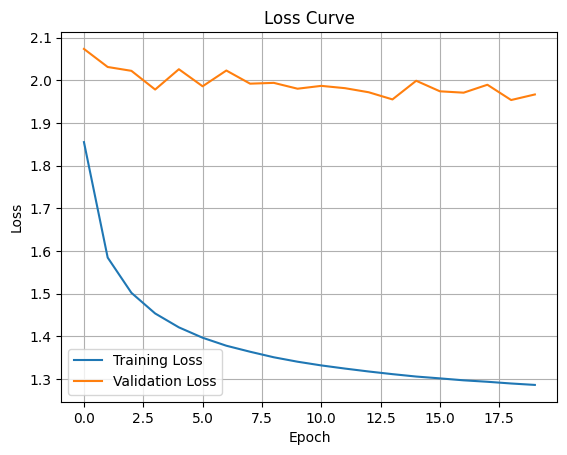

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Overall, not bad results. There appears to be some slight overfitting(maybe), but overall a nice smooth decresing training curve. This suggests that the model is learning patterns. I did find it interesting that the val_loss was the lowest on epoch 14 and 19. Maybe my dataset subset is still too small. I would have loved to train this on the entire dataset, just to see the results and compare it to these.

In [ ]:
import numpy as np

def beam_search_generate(
    model,
    seed_text,
    char_to_indx,
    indx_to_char,
    window_length=50,
    beam_width=5,
    gen_length=200,
    temperature=.5,
    top_k=10,
):
    seed_encoded = [char_to_indx[c] for c in seed_text if c in char_to_indx]
    beams = [(seed_encoded, 0.0)]

    for _ in range(gen_length):
        all_candidates = []

        for seq, score in beams:
            input_seq = seq[-window_length:]
            padded_seq = [0] * (window_length - len(input_seq)) + input_seq
            x = np.array([padded_seq])

            preds = model.predict(x, verbose=0)[0]
            preds = np.log(preds + 1e-8) / temperature
            exp_preds = np.exp(preds)
            probs = exp_preds / np.sum(exp_preds)

            # Top-k sampling
            top_indices = np.argpartition(probs, -top_k)[-top_k:]
            top_probs = probs[top_indices]
            top_probs /= np.sum(top_probs)
            sampled_indices = np.random.choice(top_indices, size=beam_width, p=top_probs)

            for i in sampled_indices:
                new_seq = seq + [i]
                new_score = (score + np.log(probs[i] + 1e-8)) / len(new_seq)
                all_candidates.append((new_seq, new_score))

        beams = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

    best_seq, _ = beams[0]
    return ''.join(indx_to_char[i] for i in best_seq)

In [ ]:
# Testing how we use a prompt with style tag

print("Shakespeare Style:")
print(beam_search_generate(model, "[SHK] to be or not", char_to_indx, indx_to_char))

print("\nLyrics Style:")
print(beam_search_generate(model, "[LYR] i got sunshine on", char_to_indx, indx_to_char))

Shakespeare Style:
[SHK] to be or not [SHK] the stay the seas [SHK] the seas [SHK] the stranger [SHK] and the world the strange [SHK] the stranger [SHK] and the promise [SHK] and the strange [SHK] the strange [SHK] the stranger [SHK] the

Lyrics Style:
[LYR] i got sunshine one [SHK] the stranger [SHK] and the stranger and the thing and the the strange [SHK] the staff the stranger [SHK] the stranger [SHK] the strange [SHK] and the stall [SHK] the strength and the strange a


In [ ]:
# Prompt 1
prompt1 = "to be or not"
print("Prompt:", prompt1)

print("\nShakespeare Style:")
shk_output1 = beam_search_generate(model, "[SHK] " + prompt1, char_to_indx, indx_to_char)
print(shk_output1)

print("\nLyrics Style:")
lyr_output1 = beam_search_generate(model, "[LYR] " + prompt1, char_to_indx, indx_to_char)
print(lyr_output1)

# Prompt 2
prompt2 = "i got sunshine"
print("\n\nPrompt:", prompt2)

print("\nShakespeare Style:")
shk_output2 = beam_search_generate(model, "[SHK] " + prompt2, char_to_indx, indx_to_char)
print(shk_output2)

print("\nLyrics Style:")
lyr_output2 = beam_search_generate(model, "[LYR] " + prompt2, char_to_indx, indx_to_char)
print(lyr_output2)

Prompt: to be or not

Shakespeare Style:
[SHK] to be or not [SHK] the strange [SHK] the strange [SHK] and the strange [SHK] and the stay the thing and the thing and the then [SHK] the strength and the strange [SHK] and the thing and the more [SHK] the strange

Lyrics Style:
[LYR] to be or not [SHK] the stranger [SHK] and the stay the world [SHK] the stay the strange [SHK] and the stay the strength and the strange [SHK] and the news and the strange [SHK] and the that the seas [SHK] the str


Prompt: i got sunshine

Shakespeare Style:
[SHK] i got sunshine [SHK] the strength and the strange [SHK] the stay the true [SHK] the stranger [SHK] and the stay the strange [SHK] the stranger [SHK] the some [SHK] and the strange [SHK] the strange [SHK] and the th

Lyrics Style:
[LYR] i got sunshine [SHK] the stranger [SHK] the thing and the stranger [SHK] the stood of the strange [SHK] and the strange [SHK] the strange [SHK] the stranger of the strength and the thing and the [SHK] the world the


RESOURCES

- https://huggingface.co/docs/transformers/v4.28.1/generation_strategies

- https://huggingface.co/blog/mlabonne/decoding-strategies

- https://huggingface.co/blog/how-to-generate

- https://aman.ai/primers/ai/token-sampling/

- https://towardsdatascience.com/temperature-scaling-and-beam-search-text-generation-in-llms-for-the-ml-adjacent-21212cc5dddb/#3289